In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #seabornない人はpip installしてね
import os
from datetime import datetime
import numpy as np

# カレントディレクトリを.pyと合わせるために以下を実行
from pathlib import Path
if Path.cwd().name == "notebook":
    os.chdir("..")


# 設定
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_columns', 500)
# 浮動小数点数を小数点以下3桁で表示するように設定
pd.set_option('display.float_format', '{:.3f}'.format)


In [2]:
# Mac Matplotlibのデフォルトフォントをヒラギノ角ゴシックに設定
plt.rcParams['font.family'] = 'Hiragino Sans'

In [3]:
# Windows MatplotlibのデフォルトフォントをMeiryoに設定
# plt.rcParams['font.family'] = 'Meiryo'

In [4]:
# CSVファイルを読み込む
file_path = 'data/input/gacha_history.csv'  # ファイルパスを適切に設定してください
df = pd.read_csv(file_path)

In [5]:
df.describe()

,id,user_uid,mission_type_id,add_ticket
count,1846907.000,1846907.000,1846907.000,1846907.000
mean,923455.459,54507.219,1.111,0.067
std,533157.869,35221.334,1.796,2.750
min,1.000,1.000,0.000,-300.000
25%,461727.500,16238.000,0.000,-1.000
50%,923454.000,60264.000,1.000,1.000
75%,1385182.500,88784.000,1.000,1.000
max,1846993.000,105518.000,14.000,300.000


In [6]:
df.columns

Index(['id', 'user_uid', 'mission_type_id', 'add_ticket',
       'mission_achievement_date', 'get_ticket_date', 'updated_at'],
      dtype='object')

In [7]:
df_admin = df[(df["mission_type_id"]==8) | (df["mission_type_id"]==9)]
df_admin

,id,user_uid,mission_type_id,add_ticket,mission_achievement_date,get_ticket_date,updated_at
555156,555157,38423,8,1,2023-07-31 22:38:10,2023-07-31 22:38:10,2023-07-31 22:38:10
555167,555168,38423,9,1,2023-07-31 22:38:34,2023-07-31 22:38:34,2023-07-31 22:38:34
607088,607089,14129,8,100,2023-08-05 11:55:41,2023-08-05 11:55:41,2023-08-05 11:55:41
672801,672802,41823,8,10,2023-08-11 18:46:20,2023-08-11 18:46:20,2023-08-11 18:46:20
724675,724676,448,8,100,2023-08-17 17:49:41,2023-08-17 17:49:41,2023-08-17 17:49:41
860385,860386,2808,8,300,2023-09-02 12:05:56,2023-09-02 12:05:56,2023-09-02 12:05:56
862674,862675,77745,8,2,2023-09-02 17:13:59,2023-09-02 17:13:59,2023-09-02 17:13:59
868205,868206,2808,8,-300,2023-09-03 08:49:41,2023-09-03 08:49:41,2023-09-03 08:49:41
934497,934498,88467,9,5,2023-09-09 19:57:56,2023-09-09 19:57:56,2023-09-09 19:57:56
977531,977534,5993,8,5,2023-09-14 14:05:13,2023-09-14 14:05:13,2023-09-14 14:05:13


In [8]:
# 日付をdatetime型に変更
df['mission_achievement_date'] = pd.to_datetime(df['mission_achievement_date'], errors='coerce')
df['get_ticket_date'] = pd.to_datetime(df['get_ticket_date'], errors='coerce')
df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce')

# 4月1日以前は削除、mission_type_idの8と9を削除
df = df[(df["mission_type_id"] != 8) & (df["mission_type_id"] != 9) & (df["mission_achievement_date"] >= pd.Timestamp('2023-04-01'))]
df

,id,user_uid,mission_type_id,add_ticket,mission_achievement_date,get_ticket_date,updated_at
68,69,15094,0,-1,2023-04-01 00:00:06,2023-04-01 00:00:06,2023-04-01 00:00:06
69,70,85753,1,1,2023-04-01 00:00:06,2023-04-01 00:00:06,2023-04-01 00:00:06
71,72,15094,0,-1,2023-04-01 00:00:19,2023-04-01 00:00:19,2023-04-01 00:00:19
72,73,15094,0,-2,2023-04-01 00:03:06,2023-04-01 00:03:06,2023-04-01 00:03:06
73,74,17248,1,1,2023-04-01 00:06:49,2023-04-01 00:06:49,2023-04-01 00:06:49
74,75,41033,1,1,2023-04-01 00:06:58,2023-04-01 00:06:58,2023-04-01 00:06:58
77,78,17248,4,5,2023-04-01 00:07:05,2023-04-01 00:07:05,2023-04-01 00:07:05
78,79,17248,0,-7,2023-04-01 00:08:21,2023-04-01 00:08:21,2023-04-01 00:08:21
79,80,85753,0,-1,2023-04-01 00:11:20,2023-04-01 00:11:20,2023-04-01 00:11:20
80,81,85753,0,-1,2023-04-01 00:11:37,2023-04-01 00:11:37,2023-04-01 00:11:37


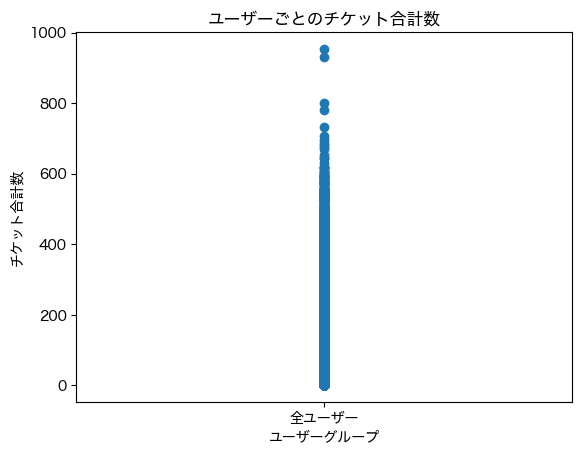

In [9]:
total_tickets_per_user = df.groupby(['user_uid'], observed=True)[
    'add_ticket'].sum()
チケット獲得合計数 = df[df['add_ticket']>0].groupby(['user_uid'], observed=True)[
    'add_ticket'].sum()

# 散布図を描画するためのy座標のみを準備（x座標は必要ない）
y = チケット獲得合計数.values

# 散布図を描画（x座標は全て1として固定）
fig, ax = plt.subplots()
ax.scatter([1] * len(y), y)

ax.set_title('ユーザーごとのチケット合計数')
ax.set_xlabel('ユーザーグループ')
ax.set_ylabel('チケット合計数')

# x軸の目盛りを調整
ax.set_xticks([1])
ax.set_xticklabels(['全ユーザー'])

plt.show()


1 145


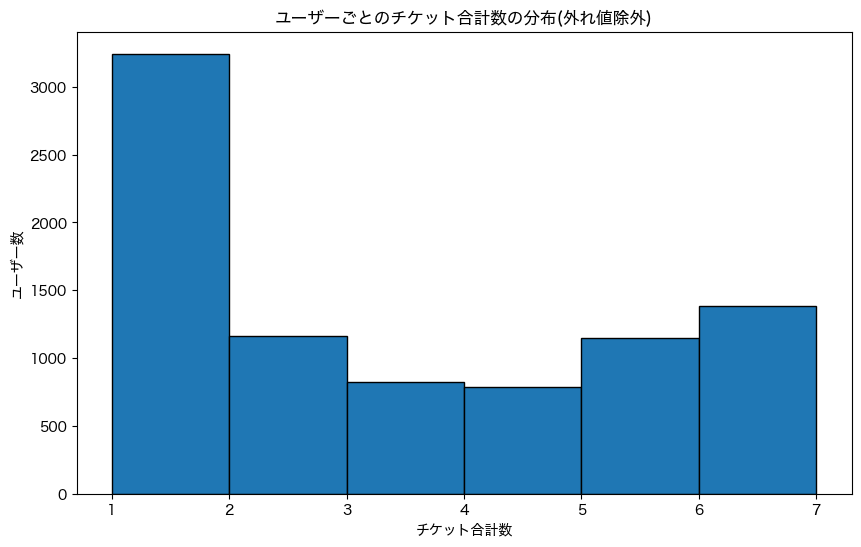

In [10]:
# 第一四分位数（Q1）と第三四分位数（Q3）を計算
Q1 = チケット獲得合計数.quantile(0.25)
Q3 = チケット獲得合計数.quantile(0.75)

# 四分位範囲（IQR）を計算
IQR = Q3 - Q1

# 外れ値の範囲を定義
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を除外
filtered_data = チケット獲得合計数[(チケット獲得合計数 >= lower_bound) & (チケット獲得合計数 <= upper_bound)]

# ヒストグラムのビンの数を10分割に設定
bin_count = 6

# チケットの最小値と最大値を取得
min_tickets = min(filtered_data)
max_tickets = max(filtered_data)
print(min_tickets,max_tickets)

# ビンの幅を計算
# bin_width = (max_tickets - min_tickets) / bin_count
bin_width = 1

# ビンの範囲を設定
bins = [min_tickets + i * bin_width for i in range(bin_count + 1)]

# ヒストグラムを描画
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=bins, edgecolor='black')
plt.title('ユーザーごとのチケット合計数の分布(外れ値除外)')
plt.xlabel('チケット合計数')
plt.ylabel('ユーザー数')
# plt.xticks(range(min(total_tickets_per_user), max(total_tickets_per_user) + 1))
plt.show()

In [11]:
# ミッション達成日時ごとの一人当たりの獲得チケット量
average_ticket_by_decade = df.groupby('mission_achievement_date', observed=True)['add_ticket'].mean()
print(average_ticket_by_decade)

# 棒グラフで表示　時間かかるのでコメントアウト
# plt.bar(average_ticket_by_decade.index, average_ticket_by_decade)

mission_achievement_date
2023-04-01 00:00:06     0.000
2023-04-01 00:00:19    -1.000
2023-04-01 00:03:06    -2.000
2023-04-01 00:06:49     1.000
2023-04-01 00:06:58     1.000
2023-04-01 00:07:05     5.000
2023-04-01 00:08:21    -7.000
2023-04-01 00:11:20    -1.000
2023-04-01 00:11:37    -1.000
2023-04-01 00:13:59     1.000
2023-04-01 00:14:05    -1.000
2023-04-01 00:17:14     1.000
2023-04-01 00:17:29     1.000
2023-04-01 00:17:54     5.000
2023-04-01 00:18:12    -1.000
2023-04-01 00:18:19    -7.000
2023-04-01 00:18:26     1.000
2023-04-01 00:18:54     5.000
2023-04-01 00:19:23    -6.000
2023-04-01 00:25:47     1.000
2023-04-01 00:25:59    -1.000
2023-04-01 00:28:47     1.000
2023-04-01 00:28:52    -1.000
2023-04-01 00:32:38     1.000
2023-04-01 00:32:44    -1.000
2023-04-01 00:32:48     3.000
2023-04-01 00:32:57     1.000
2023-04-01 00:33:59     1.000
2023-04-01 00:34:16    -1.000
2023-04-01 00:49:12     1.000
2023-04-01 00:50:37    -2.000
2023-04-01 01:13:08     1.000
2023-04-01 01:1

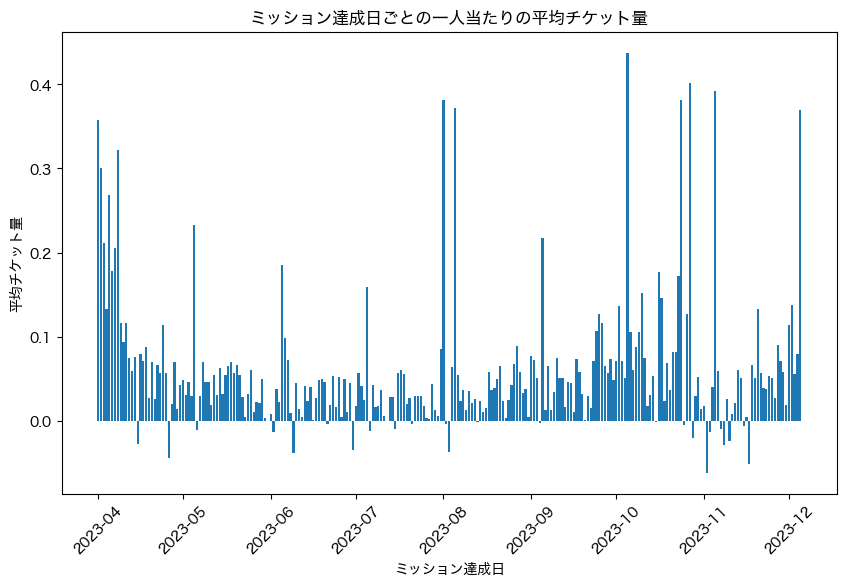

In [12]:
# ミッション達成日時のデータ型を確認し、日付型に変換
df['mission_achievement_date'] = pd.to_datetime(df['mission_achievement_date'])

# ミッション達成日ごとにグループ化して一人当たりの平均チケット量を計算
# 日時データから日付のみを抽出
df['mission_achievement_date'] = df['mission_achievement_date'].dt.date

average_ticket_by_date = df.groupby('mission_achievement_date')['add_ticket'].mean()
# print(average_ticket_by_date)

# 棒グラフで表示
plt.figure(figsize=(10, 6))
plt.bar(average_ticket_by_date.index, average_ticket_by_date)
plt.title('ミッション達成日ごとの一人当たりの平均チケット量')
plt.xlabel('ミッション達成日')
plt.ylabel('平均チケット量')
plt.xticks(rotation=45)
plt.show()

In [13]:
# mission_type_id 毎の数を算出
# 棒グラフにプロット

n_mission_type_id = df["mission_type_id"].value_counts().sort_index()
print(n_mission_type_id)

mission_type_id
0     772216
1     757368
2      85717
3      79037
4      50853
5      76887
11      2931
12     15494
14      5599
Name: count, dtype: int64


・mission_type_idの6（古紙の持込重量ミッション(来月)）,10（チケット条件一致付与(メール)）がない  
・7と13はそもそも存在しない  

・このあたりのデータは削除でよいのではないか

ガチャの効果を測定する  
・ガチャとリサイクル量の相関  
・ログインとリサイクル量の相関

# 以降、結合を試しています

In [14]:
# user_info とidを紐づけ（試し）
file_path_user_info = 'data/input/user_info_cleansing.csv'  # ファイルパスを適切に設定してください
df_user_info = pd.read_csv(file_path_user_info)
df_user_info.head()

,Unnamed: 0,id,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode
0,3,100000,きょうこ,755.000,0.000,119.000,119.000,0.000,0,女,1969-04-13 00:00:00,3111535.000
1,4,100001,あみ,168.000,168.000,53.000,53.000,0.000,1,無回答,1985-12-24 00:00:00,9830005.000
2,5,100002,ちゃちゃしめ,564.000,7.000,20.800,20.800,0.000,0,女,1986-11-23 00:00:00,9891202.000
3,6,100003,桜小路小梅,38.000,0.000,8.000,8.000,0.000,0,女,1992-12-09 00:00:00,9813109.000
4,7,100004,はるさん,2.000,6.000,2.700,2.700,0.000,0,男,1998-02-03 00:00:00,NaN


In [15]:
# birth_dayをdatetimeに変換し、年代を計算
df_user_info['birth_day'] = pd.to_datetime(df_user_info['birth_day'], errors='coerce')
current_year = pd.Timestamp.now().year
df_user_info['age'] = current_year - df_user_info['birth_day'].dt.year
# 年齢と性別が欠損している行を削除
data_age_gender = df_user_info.dropna(subset=['age', 'gender']).copy()
# 年齢を年代に変換
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_user_info['age_group'] = pd.cut(df_user_info['age'], bins=bins, labels=labels, right=False)

In [16]:
# チケット獲得合計数.name = 'チケット獲得合計数'
tempDf = チケット獲得合計数.to_frame()
tempDf.rename(columns={'add_ticket': 'チケット獲得合計数'}, inplace=True)
tempDf = tempDf.reset_index()

# display(tempDf)

df_user_info = pd.merge(df_user_info, tempDf, left_on='id', right_on='user_uid', how='left')

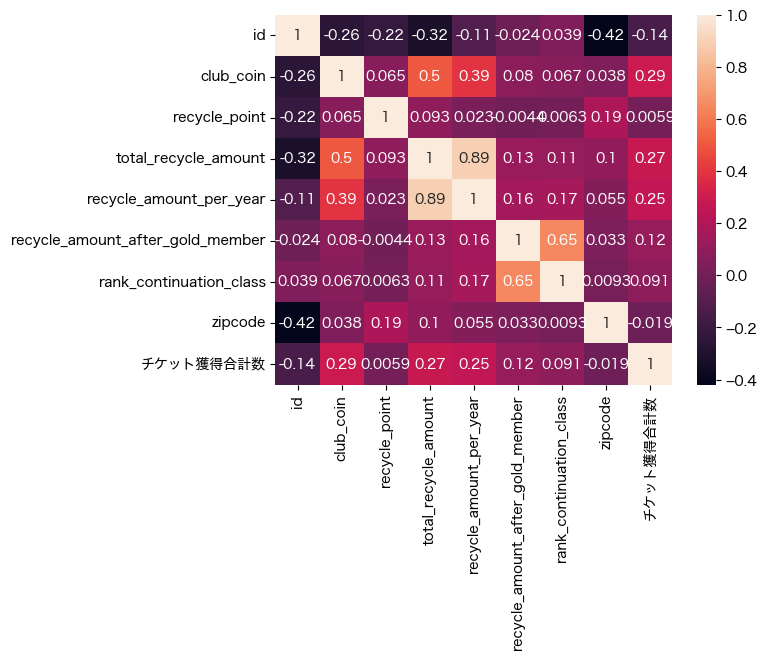

In [17]:
# カラムを選択して相関係数を算出
selected_columns = ['id', 'club_coin', 'recycle_point',
       'total_recycle_amount', 'recycle_amount_per_year',
       'recycle_amount_after_gold_member', 'rank_continuation_class','zipcode', 'チケット獲得合計数']
correlation_matrix = df_user_info[selected_columns].corr()

# チケット獲得合計数とリサイクル量・リサイクル頻度の相関を確認するためのヒートマップ
sns.heatmap(correlation_matrix, annot=True)
plt.show()


In [20]:
# 横軸を対数に変換した散布図行列を表示
df_user_info = df_user_info[df_user_info['チケット獲得合計数'] > 0 ]

# 対数変換を行いたいカラムを選択
columns = ['total_recycle_amount', 'recycle_amount_per_year', 'チケット獲得合計数']

# 対数変換を行うラムダ式を定義し、適用
df_user_info['log_total_recycle_amount'] = df_user_info['total_recycle_amount'].apply(lambda x: np.log(x) if (x > 0) else x)
df_user_info['log_recycle_amount_per_year'] = df_user_info['recycle_amount_per_year'].apply(lambda x: np.log(x) if (x > 0) else x)
df_user_info['log_チケット獲得合計数'] = df_user_info['チケット獲得合計数'].apply(lambda x: np.log(x) if (x > 0) else x)

df_user_info.describe()

,Unnamed: 0,id,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,birth_day,zipcode,age,user_uid,チケット獲得合計数,log_total_recycle_amount,log_recycle_amount_per_year,log_チケット獲得合計数
count,22853.000,22853.000,22853.000,22853.000,22853.000,22853.000,22853.000,22853.000,17421,22418.000,17421.000,22853.000,22853.000,22853.000,22853.000,22853.000
mean,56583.125,61488.743,911.008,13.069,185.317,123.848,3.886,0.488,1970-11-16 01:58:37.341140004,6693042.526,52.617,61488.743,66.640,4.486,4.190,2.985
min,3.000,77.000,0.000,0.000,0.000,0.000,0.000,0.000,1922-02-02 00:00:00,1167189.000,7.000,77.000,1.000,-0.431,-0.431,0.000
25%,27557.000,29846.000,114.000,0.000,38.000,33.000,0.000,0.000,1962-09-21 00:00:00,3160023.000,45.000,29846.000,6.000,3.638,3.497,1.792
50%,62720.000,70718.000,427.000,0.000,101.000,83.000,0.000,0.000,1970-05-01 00:00:00,9608055.000,53.000,70718.000,19.000,4.615,4.419,2.944
75%,86787.000,92040.000,1437.000,0.000,227.000,160.000,0.000,1.000,1978-07-02 00:00:00,9813203.000,61.000,92040.000,72.000,5.425,5.075,4.277
max,99815.000,105512.000,51900.000,3614.000,16880.000,12640.000,149.700,5.000,2016-09-01 00:00:00,9996401.000,101.000,105512.000,954.000,9.734,9.445,6.861
std,32503.692,33679.159,1386.477,60.963,350.960,231.991,17.325,0.877,NaN,3307360.504,11.669,33679.159,103.685,1.305,1.270,1.712


#### TODO: リサイクル量ではなくリサイクル回数でも相関出してみよう

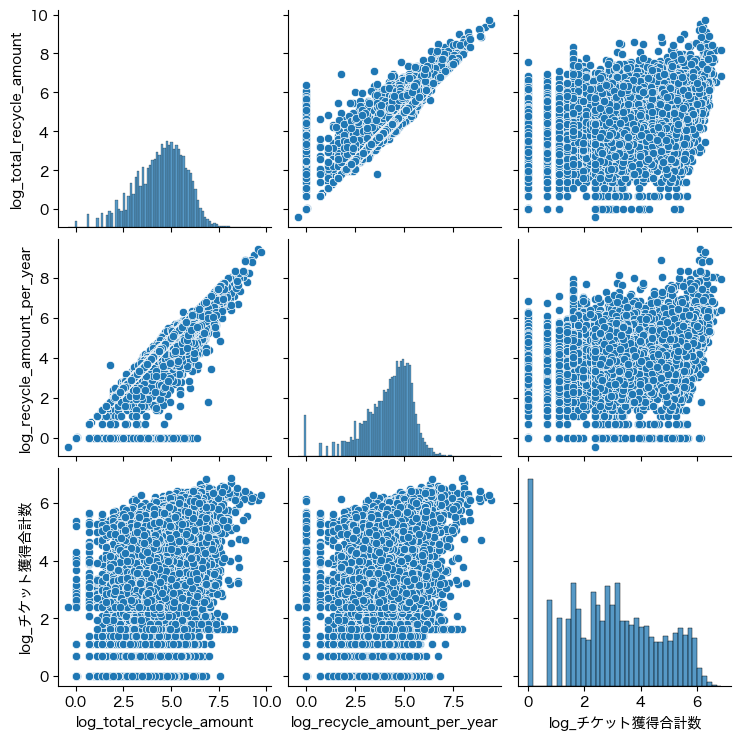

In [22]:
# # 対数変換されたカラムで散布図行列を表示
log_columns = ['log_total_recycle_amount','log_recycle_amount_per_year','log_チケット獲得合計数']
sns.pairplot(df_user_info[log_columns])

In [ ]:
# merge (左外部結合)
df_merge = pd.merge(df, df_user_info, left_on='user_uid', right_on='id', how='left')

In [ ]:
display(df_merge.head(100))
display(df_merge.describe())
#print(len(df_merge["user_uid"].unique()))
#print(df_merge.info(verbose=True, show_counts=True))
print(df_merge['nickname'].isna().sum())

・user_info は最近やってなかったユーザーを消しているのか？  
・user_info は宮城県で絞ってないか？  
-> user_infoをどのように抽出したかの詳細を聞く必要がある

In [ ]:
# # userIdごとのレコードの出現回数を取得
# record_counts = df_merge.groupby('user_uid_x').size().reset_index(name='record_count')
# record_counts

In [ ]:
# アクティブユーザーと見なされる最小出現回数
threshold = 10

# 'user_id'の出現回数をカウント
user_counts = df_merge['user_uid_x'].value_counts()

# アクティブユーザーを識別
df_merge['アクティブユーザ'] = df_merge['user_uid_x'].apply(lambda x: 1 if (user_counts[x] >= threshold) else 0)


In [ ]:
df_merge.head()

In [ ]:
columns = ['アクティブユーザ','total_recycle_amount','recycle_amount_per_year', 'チケット獲得合計数']
# total_recycle_amountが５０００以上を除外した場合
sns.pairplot(df_merge[df_merge['total_recycle_amount']<5000][columns],hue='アクティブユーザ')

# アクティブユーザーごとの相関を出したかったが、うまく定義できず中断
# 一応コードは残してます。

In [ ]:
# 年代ごとのチケット獲得枚数合計を算出
年代ごとのチケット獲得枚数合計 = df_merge[df_merge['add_ticket']>0].groupby('age_group')['add_ticket'].sum()
年代ごとのチケット獲得枚数平均 = df_merge[df_merge['add_ticket']>0].groupby('age_group')['add_ticket'].mean()

In [ ]:
年代ごとのチケット獲得枚数平均

・年齢ごとに大きな差は見受けられなかった。。。